# **Персонализация предложений для клиентов интернет-магазина**

## **Введение:**



### *Описание проекта:*
    Изучим данные, предоставленные магазином "В один клик". С помощью моделей машинного обучения пресдкажем уровень активности клиентов, предскажем вероятность снижения покупательской активности. Выделим сегменты покупателей и разработаем персонализированные предложения.
### *Цель проекта:*
    Главная цель - разработать модель, для предсказывания покупательской способности клиентов. Разработать предложения по увелечению покупательской способности.
### *Описание данных:*
    Таблица market_file.csv содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Данные по столбцам:
        id — номер покупателя в корпоративной базе данных.
        Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
        Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
        Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
        Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
        Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
        Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
        Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
        Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
        Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
        Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
        Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
        Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
        
    Таблица market_money.csv содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Данные по столбцам:
        id — номер покупателя в корпоративной базе данных.
        Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
        Выручка — сумма выручки за период.
    
     Таблица market_time.csv содержит данные о времени, которое покупатель провел на сайте в течение периода. Данные по столбцам:
        id — номер покупателя в корпоративной базе данных.
        Период — название периода, во время которого зафиксировано общее время.
        минут — значение времени, проведённого на сайте, в минутах.
       
     Таблица money.csv содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Данные по столбцам:
        id — номер покупателя в корпоративной базе данных.
        Прибыль — значение прибыли.

### *План работы:*
    1. Загрузка данных, изучение общей информации
    2. Предобработка данных: проверим аномальные значения, пропуски, дубликаты, типы данных
    3. Исследовательский анализ данных: отберем клиентов с покупательской активностью не менее трех месяцев.
    4. Корреляционный анализ: проведем корреляционный анализ признаков в количествеой шкале итоговой таблицы для моделирования. Изучим мультиколлинеарность.
    5. Использование пайплайнов: с помощью пайплайнов применим все изученные модели
    6. Анализ важности признаков: оценим важность признаков и построим график важности с помощью SHAP
    7. Сегментация покупателей: выполним сегментацию покупателей.
    8. Общий вывод.

In [1]:
! pip install -q --upgrade scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Это бааааза, base
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# анализ
from scipy.stats import probplot, shapiro

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Подготовка данных + search
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# Модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# метрики
from sklearn.metrics import roc_auc_score, RocCurveDisplay, recall_score, precision_score, \
accuracy_score, confusion_matrix
import shap

#регулярные выражения
import re

## **Загрузка данных**

### Загрузим данные из четырех таблиц

In [3]:
df_market_file = pd.read_csv('/datasets/market_file.csv')
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_market_time = pd.read_csv('/datasets/market_time.csv')
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

### Изучим данные

In [4]:
dict_df = {'Таблица market_file (данные о поведении покупателя на сайте)':df_market_file, \
           'Таблица market_money (данные о выручке, которую получает магазин с покупателя)':df_market_money, \
           'Таблица market_time (данные о времени, которое покупатель провел на сайте в течение периода)' \
           :df_market_time, \
          'Таблица money (данные о среднемесячной прибыли покупателя за последние 3 месяца)':df_money}
for key, value in dict_df.items():
    display(value.head().style.set_caption(key))
    print('\n')

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400000,5,121,0.000000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400000,4,819,0.750000,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900000,3,539,0.140000,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200000,5,896,0.990000,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100000,3,1064,0.940000,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000000
1,215348,текущий_месяц,3293.100000
2,215348,предыдущий_месяц,0.000000
3,215349,препредыдущий_месяц,4472.000000
4,215349,текущий_месяц,4971.600000


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.980000
1,215349,4.160000
2,215350,3.130000
3,215351,4.870000
4,215352,4.210000


Можно изменить некоторые названия столбцов. Убрать пробелы и привести к нижнему регистру. Сделаем это в части предобработки.

In [5]:
for i in dict_df.values():
    display(i.info(), i.describe())
    print('\n'*2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


### *Вывод*
    - все заявленные признаки присутствуют.
    - пропусков не наблюдается.
    - типы данных впорядке. 
    - стоит проверить данные на дубликаты.

## **Предобработка данных**

### Изменим названия столбцов, в которых присутствуют заглавные буквы и пробелы

In [6]:
for value in dict_df.values():
    value.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i.replace(' ', '_')).lower() for i in value.columns]

### Проверим на наличие дубликатов

Сначала поработаем с опечатками в данных

In [7]:
for key, value in dict_df.items():
    print(f'df_{key.split()[1]}:')
    for i in value:
        if value[i].dtypes == 'object':
            print(f'\t- {i}: {value[i].unique()}')
    print('\n')

df_market_file:
	- покупательская_активность: ['Снизилась' 'Прежний уровень']
	- тип_сервиса: ['премиум' 'стандартт' 'стандарт']
	- разрешить_сообщать: ['да' 'нет']
	- популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


df_market_money:
	- период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


df_market_time:
	- период: ['текущий_месяц' 'предыдцщий_месяц']


df_money:




Видим, что в df_market_file в признаке `тип_сервиса` есть опечатка в данных. Присутствует опечатка в таблице df_market_time в признаке `период`.

Избавимся от всех неточностей

In [8]:
df_market_file['тип_сервиса'] = (df_market_file['тип_сервиса']
                                 .apply(lambda x: 'стандарт' if x == 'стандартт' else x)
                                )
df_market_time['период'] = (df_market_time['период']
                            .apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)
                           )

Проверим на явные дубликаты

In [9]:
print('Явные дубликаты')
for key, value in dict_df.items():
    print(f'df_{key.split()[1]}: {value.duplicated().sum()}')

Явные дубликаты
df_market_file: 0
df_market_money: 0
df_market_time: 0
df_money: 0


Удалим дубликаты в таблице df_market_money

In [10]:
df_market_money = df_market_money.drop_duplicates()
df_market_money.duplicated().sum()

0

Так же проверим не повторяются ли id клиентов в таблицах

In [11]:
print('Дубликаты по id')
for key, value in dict_df.items():
    print(f'df_{key.split()[1]}: {value.duplicated("id").sum()}')

Дубликаты по id
df_market_file: 0
df_market_money: 2600
df_market_time: 1300
df_money: 0


Повторения есть, однако скорее всего это связано с разным периодом в столбце период. Проверим дубликаты для каждого периода

In [12]:
print('df_market_money')
for i in df_market_money['период'].unique():
    print(f"{i}: {df_market_money[df_market_money['период'] == i].duplicated('id').sum()}")
print('\ndf_market_time')
for i in df_market_time['период'].unique():
    print(f"{i}: {df_market_time[df_market_time['период'] == i].duplicated('id').sum()}")

df_market_money
препредыдущий_месяц: 0
текущий_месяц: 0
предыдущий_месяц: 0

df_market_time
текущий_месяц: 0
предыдущий_месяц: 0


Если разделить по периодам, то дубликатов не наблюдается.

### *Вывод*
    - исправили некорректные названия признаков
    - удалили дубликаты
    - исправили опечатки в данных

## **Исследовательский анализ данных**

### Вспомогательные функции для анализа признаков

Главная функция выбора графиков

In [13]:
def control_of_analysis_graphs(df, column, xlabel, title, \
                               range_size_hist=(0, 0), bins=25, hist=True):
    
    
    # Разбиваем на подгруппы с и без снижения активности
    activity_decreased, previous_activity = separate(df)
    
    # строим графики
    if hist:
        plt.figure(figsize=(15, 5));
        plt.suptitle(title, fontweight='bold', fontsize=16)
        hist_print(activity_decreased[column], previous_activity[column], column, range_size_hist, xlabel, bins)
        qqplot_print(df, column, xlabel)
    boxplot_print(activity_decreased[column], previous_activity[column], column, xlabel)
    shapiro_test(df, column)

In [14]:
def separate(df):
    activity_decreased = df[df['покупательская_активность'] == 'Снизилась']
    previous_activity = df[df['покупательская_активность'] == 'Прежний уровень']
    return activity_decreased, previous_activity

Функция построение гистограммы

In [15]:
def hist_print(activity_decreased, previous_activity, column, range_size, xlabel, bins):
    plt.subplot(1, 2, 1);
    plt.hist([activity_decreased, previous_activity], stacked = True, range=range_size, bins=bins);
    plt.grid()
    plt.title('Распределение значений')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel('Частота', fontsize=13)
    plt.legend(['Снизилась', 'Прежний уровень'])

Функция проведения теста Шапиро-Уилка

In [16]:
def shapiro_test(df, column):
    shapiro_result = shapiro(df[column])
    if shapiro_result[1] >= 0.05:
        print(f'Распределение нормальное, p-значение = {shapiro_result[1]}')
    else:
        print(f'Распределение не является нормальным, p-значение = {shapiro_result[1]}' )

Функция построения графика разброса

In [17]:
def boxplot_print(activity_decreased, previous_activity, column, xlabel):
    plt.figure(figsize=(15, 5));
    ax = plt.subplot()
    ax.boxplot([activity_decreased, previous_activity])
    ax.set_xticklabels(['Снизилась', 'Прежний уровень'])
    plt.title('График разброса')
    plt.grid()
    plt.show()

Функция построения Q-Q plot

In [18]:
def qqplot_print(df, column, ylabel):
    plt.subplot(1, 2, 2)
    probplot(df[column], plot=plt);
    plt.ylabel(ylabel, fontsize=13)
    plt.title('Q-Q plot')
    plt.xlabel('Теоретические квантили', fontsize=13)
    plt.show()


Функция построения столбчатой диаграммы

In [19]:
def barplot_print(df, column, title, values, figsize=(7, 5)):
    activity_decreased, previous_activity = separate(df)
    activity_decreased = activity_decreased.pivot_table(index=column, values=values, aggfunc='count')
    previous_activity = previous_activity.pivot_table(index=column, values=values, aggfunc='count')
    table = pd.concat([activity_decreased, previous_activity], keys=['Снизилась', 'Прежний уровень']).reset_index()
    plt.figure(figsize=figsize)
    sns.barplot(x='level_0', y='id', hue=column, data=table)
    plt.xlabel('Покупательская активность', fontsize=13)
    plt.ylabel('количество')
    plt.title(title)

### Таблица market_file 

#### Покупательская активность

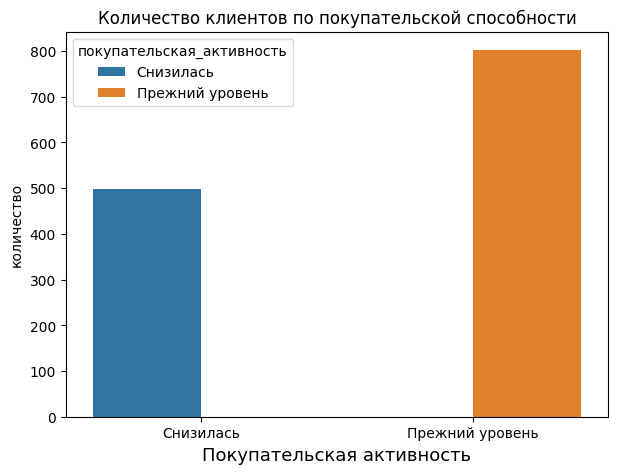

In [20]:
barplot_print(df_market_file, 'покупательская_активность', \
              'Количество клиентов по покупательской способности', 'id')

У большего количества клиентов покупательская способность осталась на прежнем уровне. Только у 500 клиентов покупательская способность снизилась.

Заметен дисбаланс классов.

#### Тип сервиса

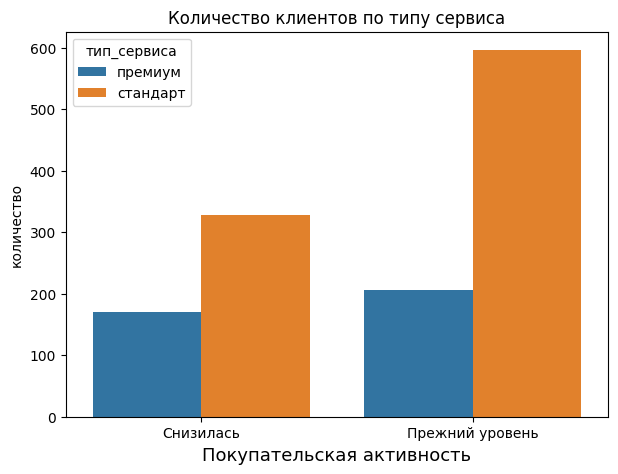

In [21]:
barplot_print(df_market_file, 'тип_сервиса', 'Количество клиентов по типу сервиса', 'id')

Клиенты с прежним уровнем активности с большей долей имеют стандартный тип сервиса, нежели клиенты, у которых активность снижается

#### Разрешить сообщать (сообщения о доп. предложениях)

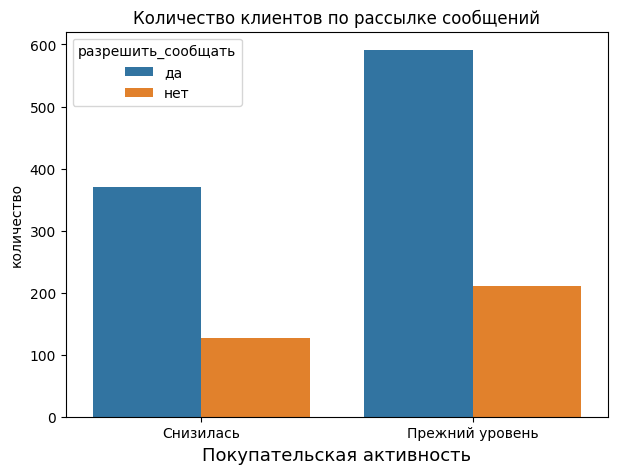

In [22]:
barplot_print(df_market_file, 'разрешить_сообщать', 'Количество клиентов по рассылке сообщений', 'id')

Заметим, что примерно в равных долях клиенты по статусу рассылки в обоих категориях

#### Маркет_актив_6_мес (среднемесячное значение маркетинговых коммуникаций компании за 6 месяцев)

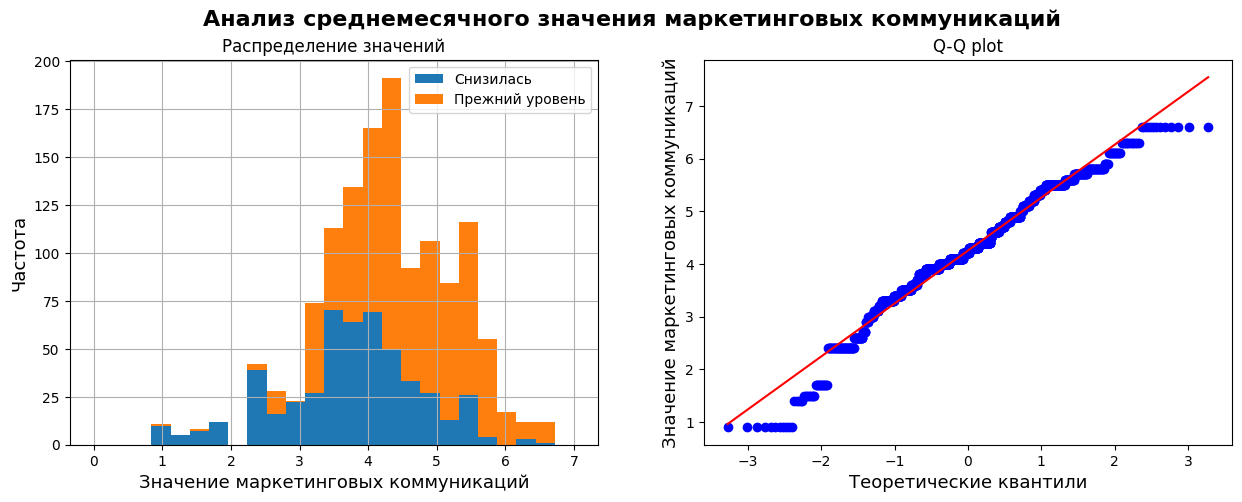

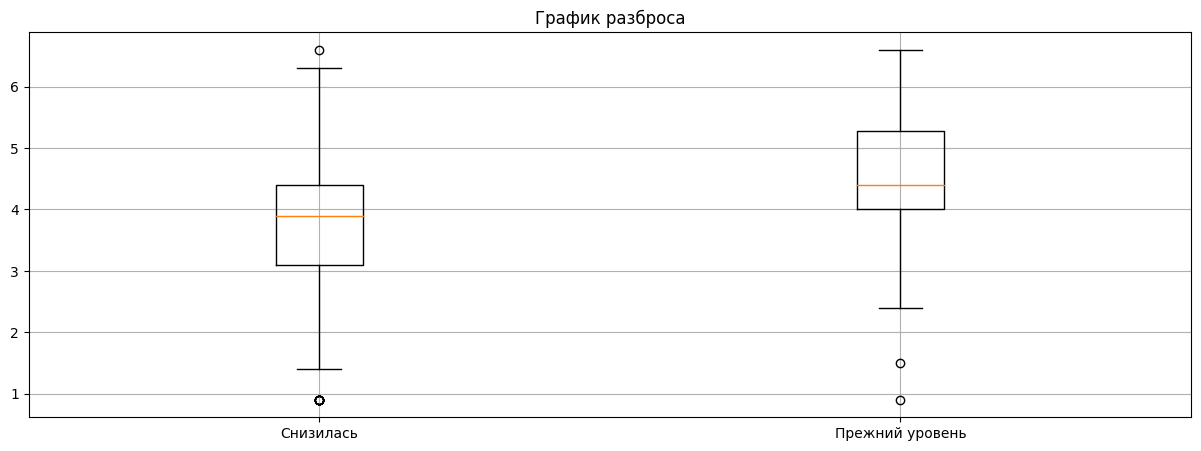

Распределение не является нормальным, p-значение = 3.3620735319025985e-13


In [23]:
control_of_analysis_graphs(df_market_file, 'маркет_актив_6_мес', \
                           'Значение маркетинговых коммуникаций', \
                           'Анализ среднемесячного значения маркетинговых коммуникаций', (0, 7))

- наблюдаются выбросы, однако мы не будем их убирать, так как данные вполне реалистичны и не относятся к ошибкам или к слишком редким показателям
- у клиентов с прежним уровнем активности значения маркетинговых коммуникаций выше, чем у тех, у кого активность снизилась
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния.

#### Маркет_актив_тек_мес (количество маркетинговых коммуникаций в текущем месяце)

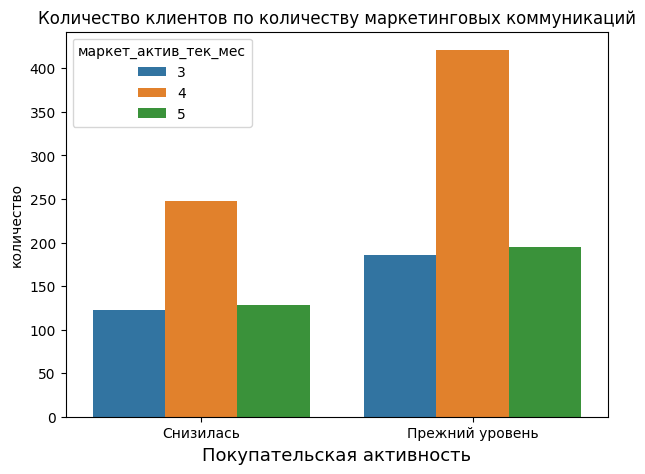

In [24]:
barplot_print(df_market_file, 'маркет_актив_тек_мес', \
              'Количество клиентов по количеству маркетинговых коммуникаций', 'id')

Со всеми клиентами проводилась маркетинговая коммуникация. Чаще всего с клиентами проводилось 4 коммуникации в текущем месяце. Доля коммуникаций примерно равна для двух групп

#### Длительность (дни с момента регистрации на сайте)

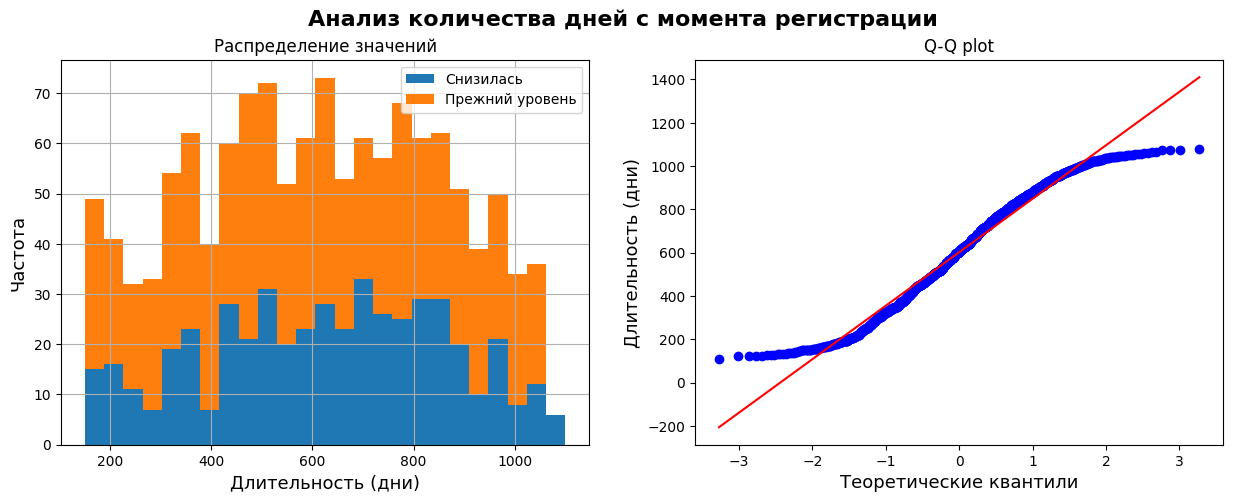

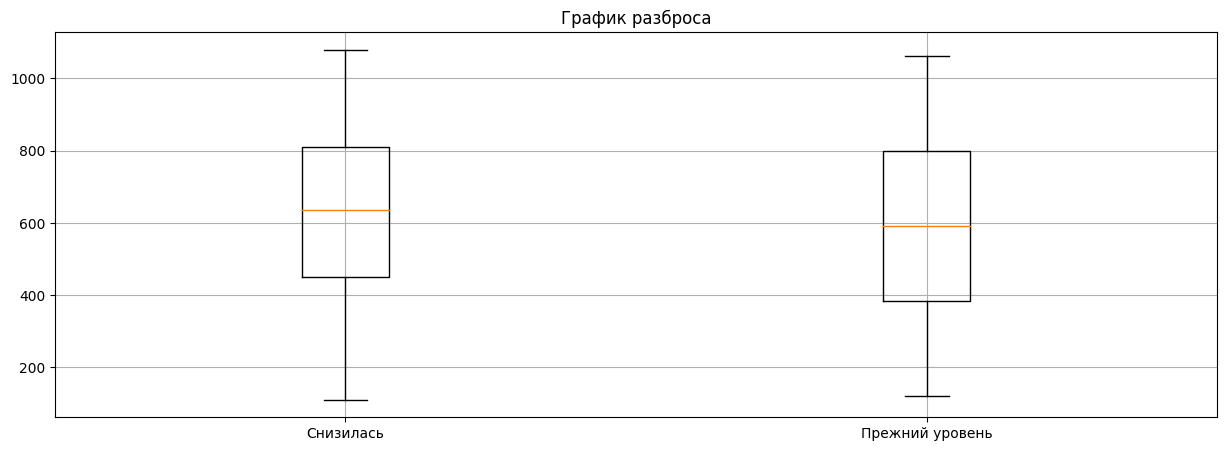

Распределение не является нормальным, p-значение = 5.791480627183451e-15


In [25]:
control_of_analysis_graphs(df_market_file, 'длительность', \
                           'Длительность (дни)', 'Анализ количества дней с момента регистрации', \
                           (150, 1100));

- клиенты, у которых активность снижается, немного дольше зарегистрированы на платформу, но не особо значительно
- выбросов не наблюдается
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния.

#### Акционные покупки (среднемесячная доля покупок по акции)

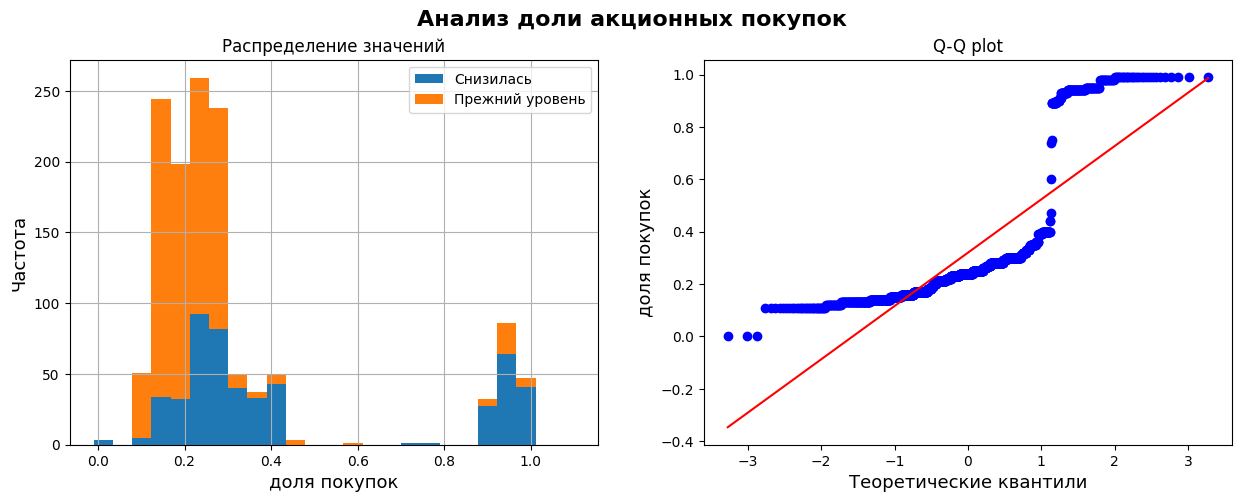

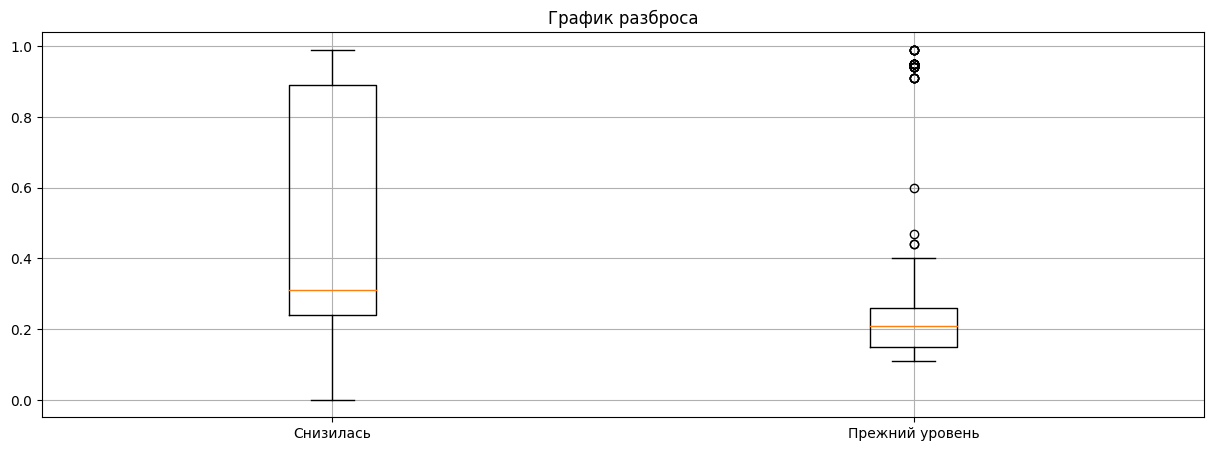

Распределение не является нормальным, p-значение = 5.605193857299268e-45


In [26]:
control_of_analysis_graphs(df_market_file, 'акционные_покупки', \
                           'доля покупок', 'Анализ доли акционных покупок', (-0.01, 1.1))

- присутствует приличное количество выбросов. Такое поведение закономерно. Акции привлекают новых клиентов, которые раннее не пользовались услугами сайта, следовательно их доля покупок по акции близка к единице. Такие клиенты значительно влияют на снижение активности. Как мы можем заметить, у клиентов, со снижающимся уровнем покупательской активности доля покупок по акции значительно выше.
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния.

#### Популярная категория (самые популярные товары)

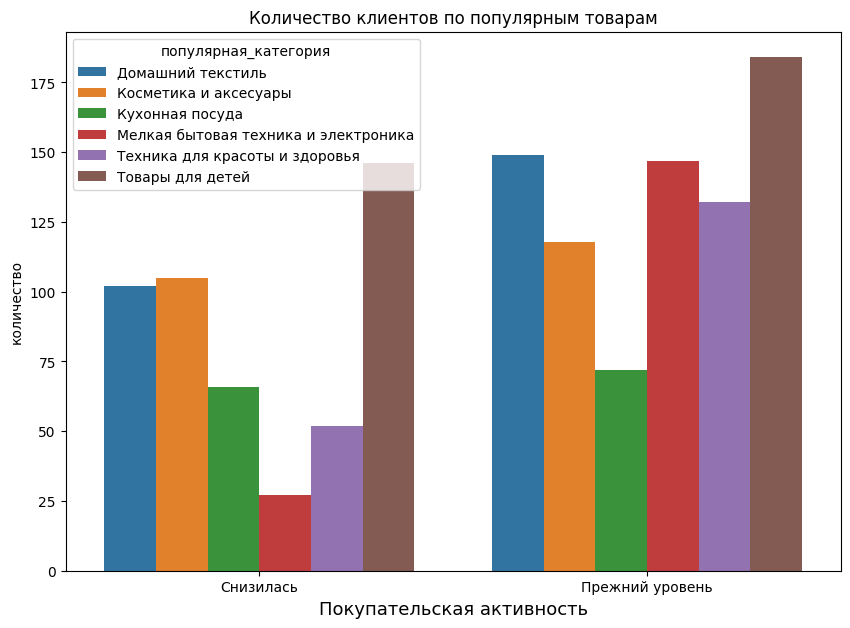

In [27]:
barplot_print(df_market_file, 'популярная_категория', 'Количество клиентов по популярным товарам', 'id', (10,7))

Самая популярная категория вне зависимости от группы - товыра для детей. Заметим, что товары из таких категорий как: мелкая бытовая техника и техника не пользуются популярностью у клиентов, у которых снижается покупательская активность. 

#### Средний просмотр категорий за визит

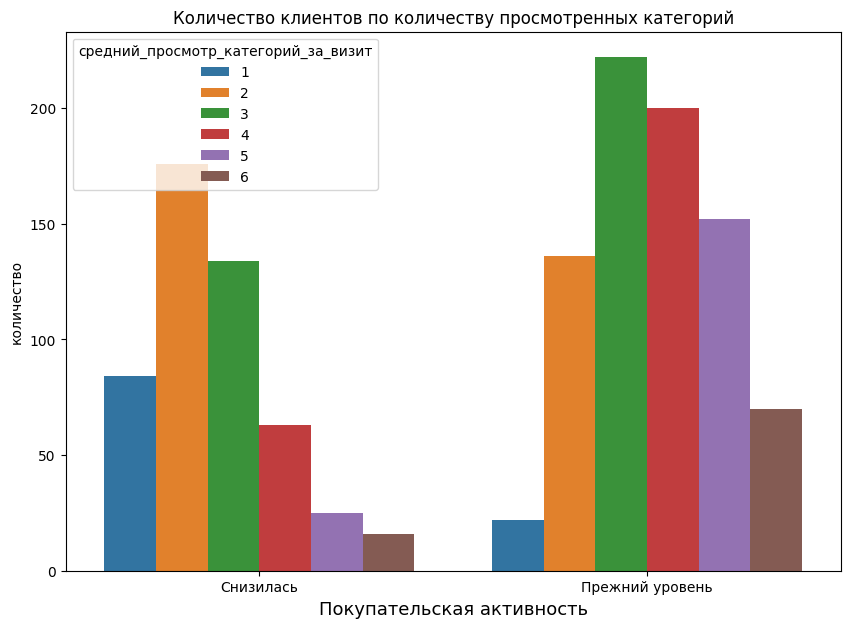

In [28]:
barplot_print(df_market_file, 'средний_просмотр_категорий_за_визит', \
              'Количество клиентов по количеству просмотренных категорий', 'id', (10,7))

Клиенты с прежним уровнем покупательской активности чаще просматривают 3 и более категорий

#### Неоплаченные продукты

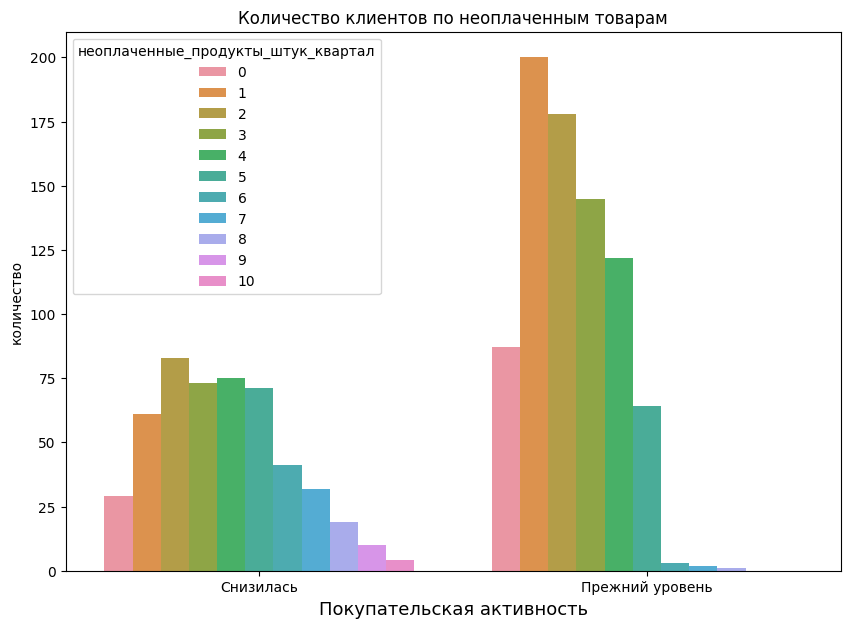

In [29]:
barplot_print(df_market_file, 'неоплаченные_продукты_штук_квартал', \
              'Количество клиентов по неоплаченным товарам', 'id', (10,7))

У клиентов с прежней покупательской активностью чаще всего 1 неоплаченный товар и очень редко встречаются клиенты с 6 и более неоплаченными товарами. А у клиентов со снижемнным уровнем чаще 2 неоплченных товара и примерно у такого же количества 3-5 товаров. Доля клиентов со сниженным уровнем активности, у которых 6 и более неоплаченных товаров больше, чем у клиентов из категории с прежним уровнем активности.

#### Ошибка сервиса (число сбоев)

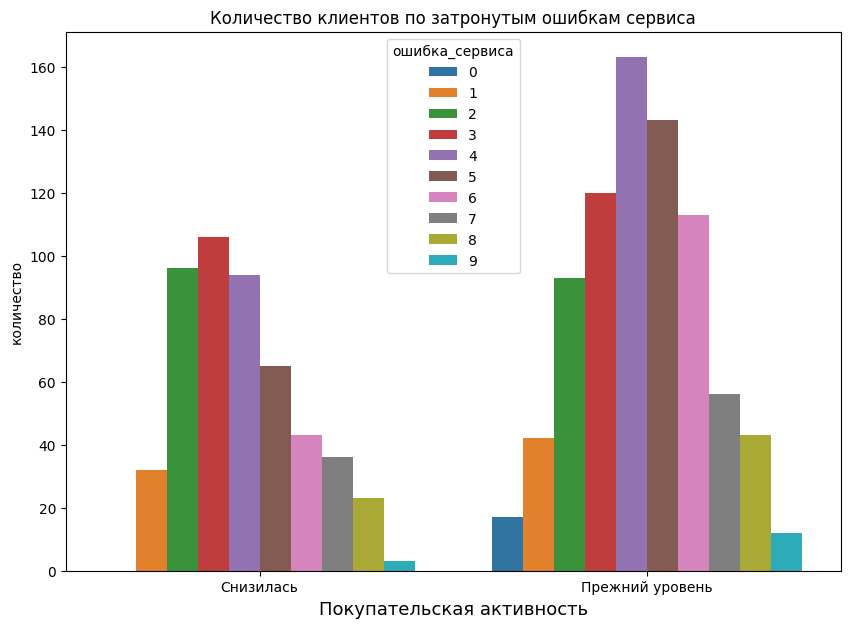

In [30]:
barplot_print(df_market_file, 'ошибка_сервиса', 'Количество клиентов по затронутым ошибкам сервиса', 'id', (10,7))

В основном клиенты сталкиваются с 4 ошибками за время посещения сайта. Чуть меньше клиентов с 3 ошибками и еще меньше с 5 ошибками

#### Страниц за визит

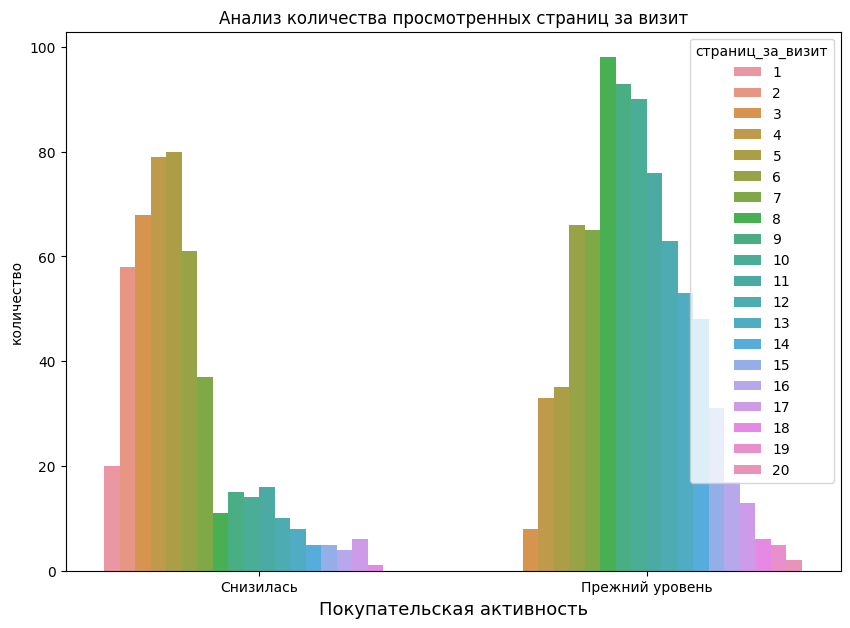

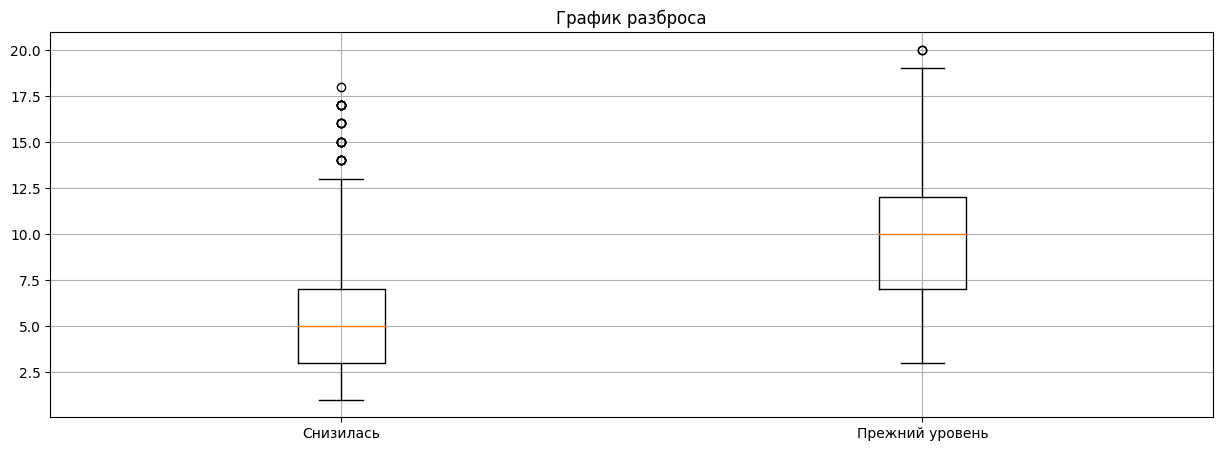

Распределение не является нормальным, p-значение = 1.2600152109296277e-14


In [31]:
barplot_print(df_market_file, 'страниц_за_визит', 'Анализ количества просмотренных страниц за визит', 'id', (10,7))
control_of_analysis_graphs(df_market_file, 'страниц_за_визит', \
                           'количество страниц', 'Анализ количества просмотренных страниц за визит', (2, 21), hist=False)

- есть небольшие выбросы в каждой группе, однакое они не аномальны, оставим их
- отчетливо видно, что клиенты с прежним уровнем активности намного больше просматривают страниц, чем те, у кого активность снизилась
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния.

### Таблица market_money 
<a id='link'></a>

#### Объединение таблиц
<a id='link'></a>

Объединим таблицы сразу, для лучшего исследования признаков

In [32]:
pivot1 = df_market_money.pivot_table(index='id', columns='период')
pivot2 = df_market_time.pivot_table(index='id', columns='период')

pivot1 = pivot1[(pivot1 > 0).all(axis=1)]
pivot1.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
pivot2.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']

In [33]:
df_for_model = df_market_file.merge(pivot1, on='id')
df_for_model = df_for_model.merge(pivot2, on='id')

#### Выручка за текущий месяц

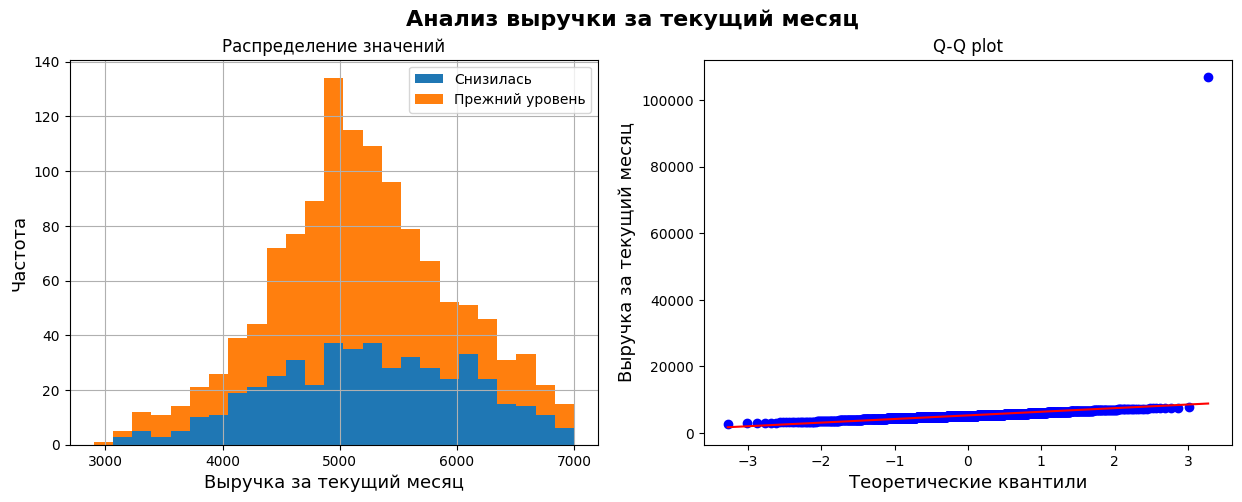

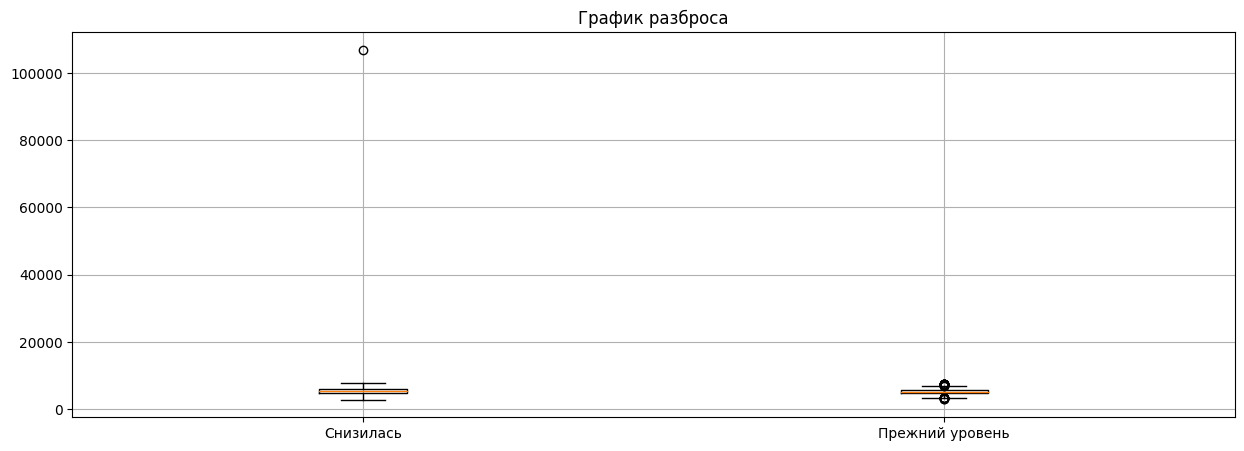

Распределение не является нормальным, p-значение = 0.0


In [34]:
control_of_analysis_graphs(df_for_model, 'выручка_текущий_месяц', \
                           'Выручка за текущий месяц', \
                           'Анализ выручки за текущий месяц', (2900, 7000))

Видим сильно выбивающееся значение. Удалим его.

In [35]:
df_for_model = df_for_model[df_for_model['выручка_текущий_месяц'] < 8000]

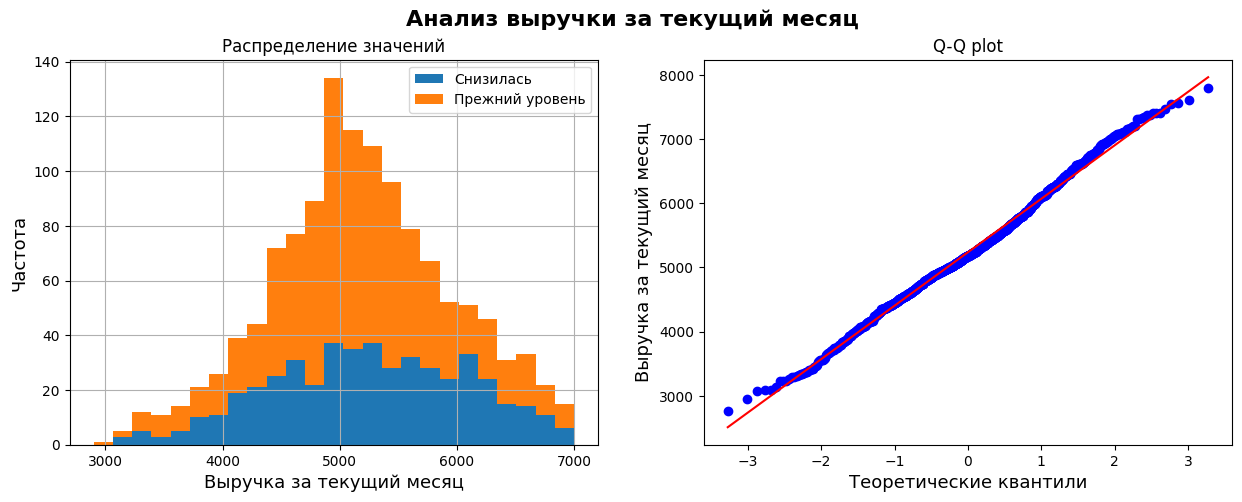

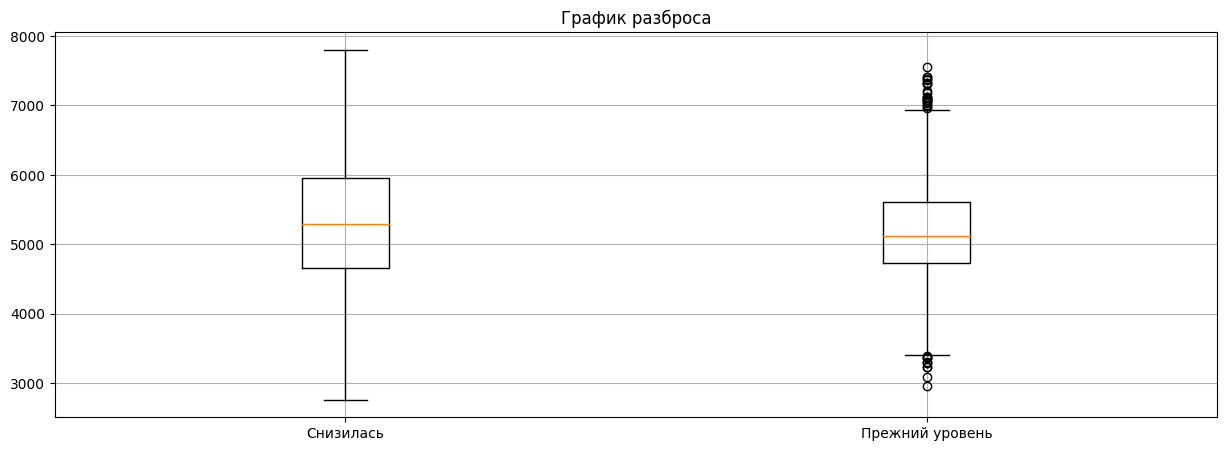

Распределение не является нормальным, p-значение = 0.00015330837049987167


In [36]:
control_of_analysis_graphs(df_for_model, 'выручка_текущий_месяц', \
                           'Выручка за текущий месяц', \
                           'Анализ выручки за текущий месяц', (2900, 7000))

- видны выбросы в данных, однако мы не будем их удалять, так как они не являются аномальными
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния. Однако, стоит заметить, что данное распределение очень похоже на нормальное
- Медианное значение выручки у клиентов, у которых активность снижается немного выше и имеет больший разброс

#### Выручка за предыдущий месяц

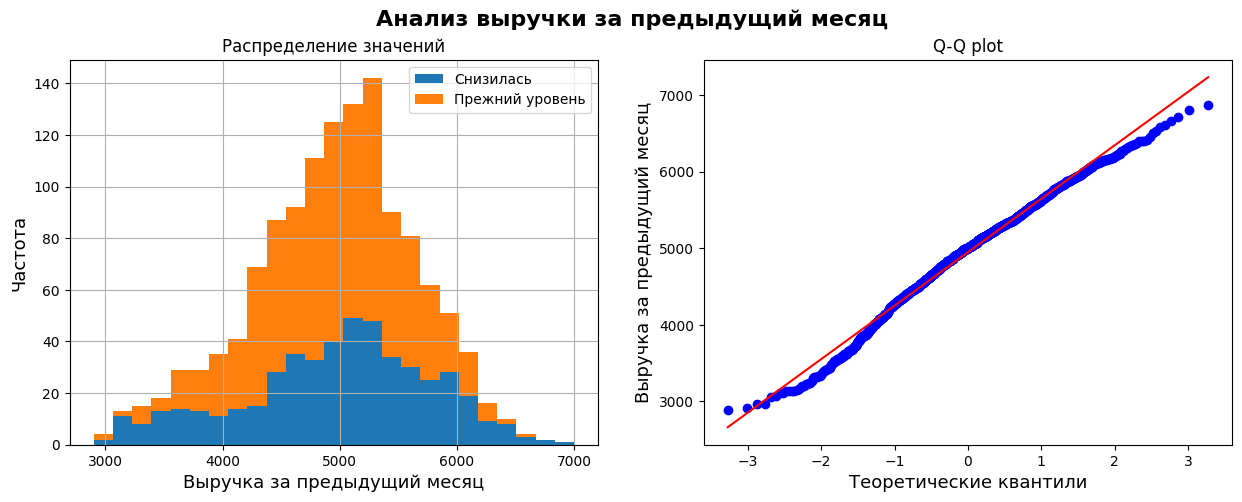

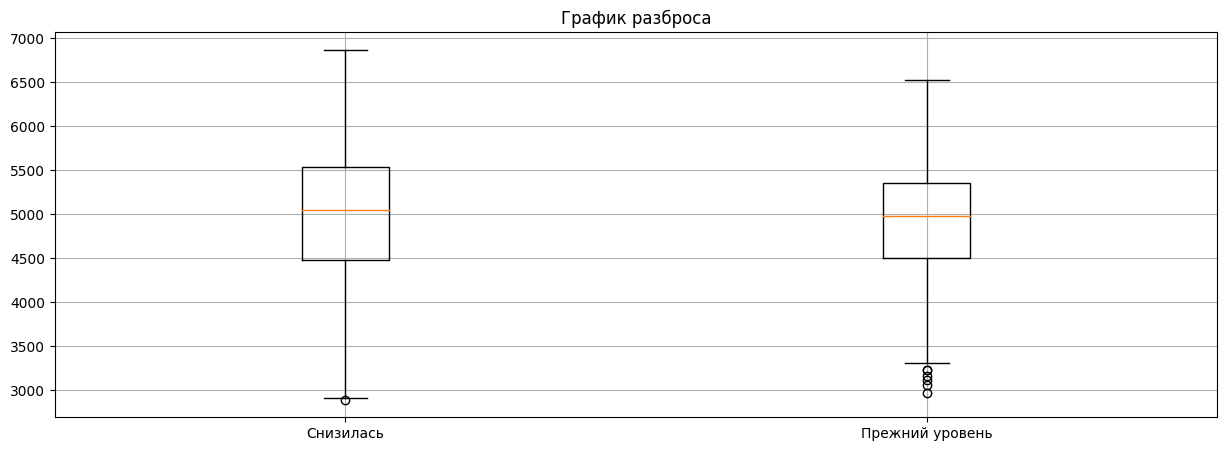

Распределение не является нормальным, p-значение = 1.3092135020542628e-07


In [37]:
control_of_analysis_graphs(df_for_model, 'выручка_предыдущий_месяц', \
                           'Выручка за предыдущий месяц', \
                           'Анализ выручки за предыдущий месяц', (2900, 7000))

- видны выбросы в данных, однако мы не будем их удалять, так как они не являются аномальными
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния. Однако, стоит заметить, что данное распределение очень похоже на нормальное
- выручка за предыдущий месяц у двух групп примерно одинаковая, однако у клиентов, у которых активность снижается, показатель выручки имеет немного больший разброс

#### Выручка за препредыдущий месяц

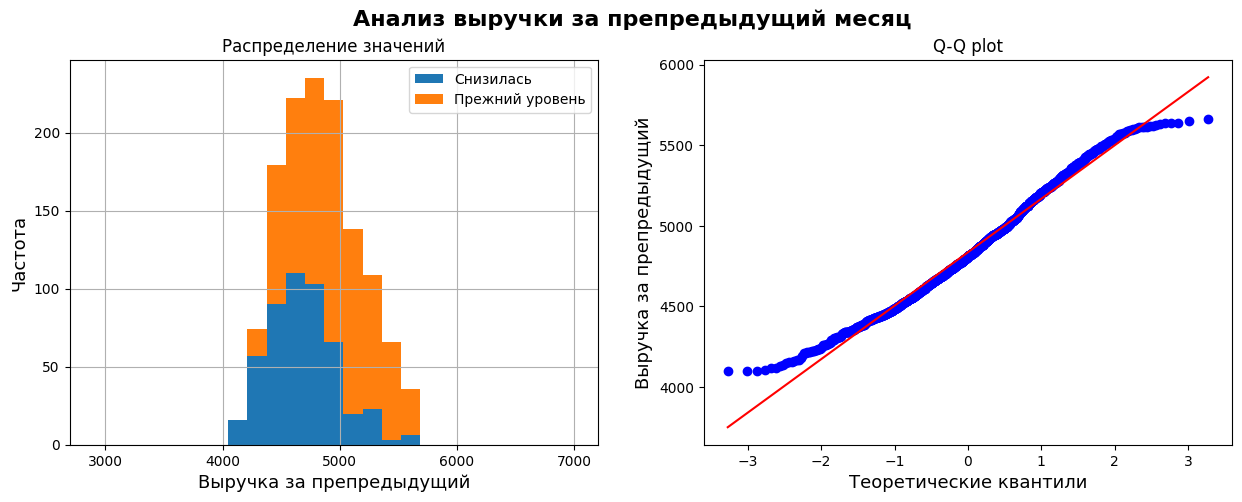

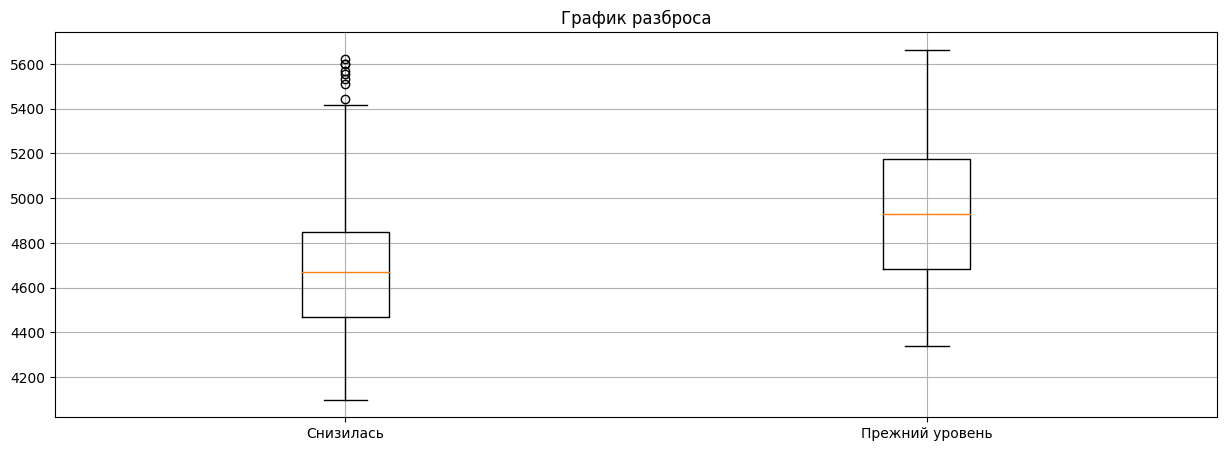

Распределение не является нормальным, p-значение = 1.1555943979502104e-09


In [38]:
control_of_analysis_graphs(df_for_model, 'выручка_препредыдущий_месяц', \
                           'Выручка за препредыдущий', \
                           'Анализ выручки за препредыдущий месяц', (2900, 7000))

- видны выбросы в данных, однако мы не будем их удалять, так как они не являются аномальными
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния.
- выручка за препредыдущий месяц значительно меньше у группы со снижающейся покупательской активностью.

### Таблица market_time 

#### Минут (время проведенное на сайте)

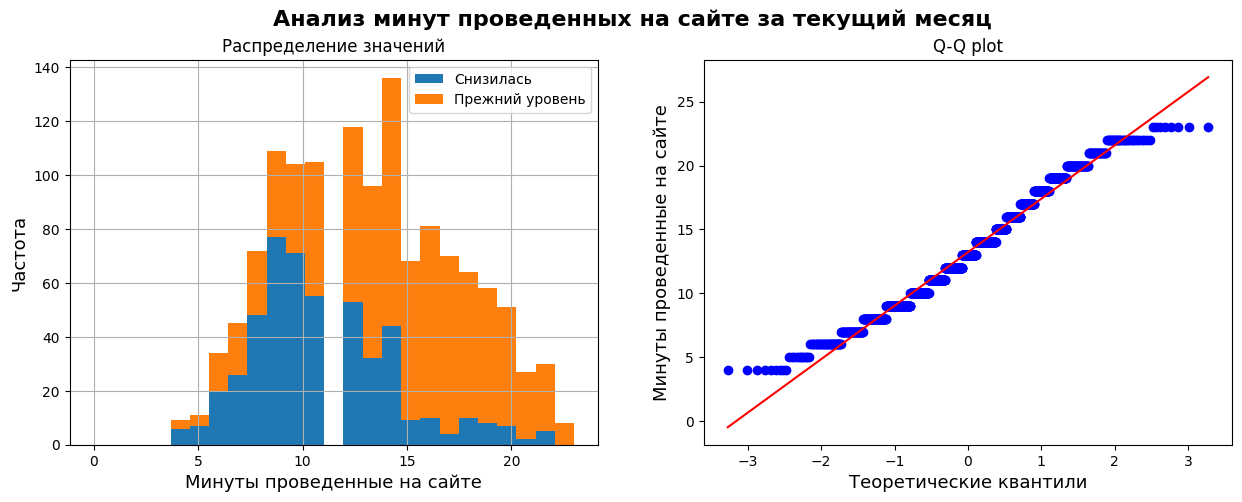

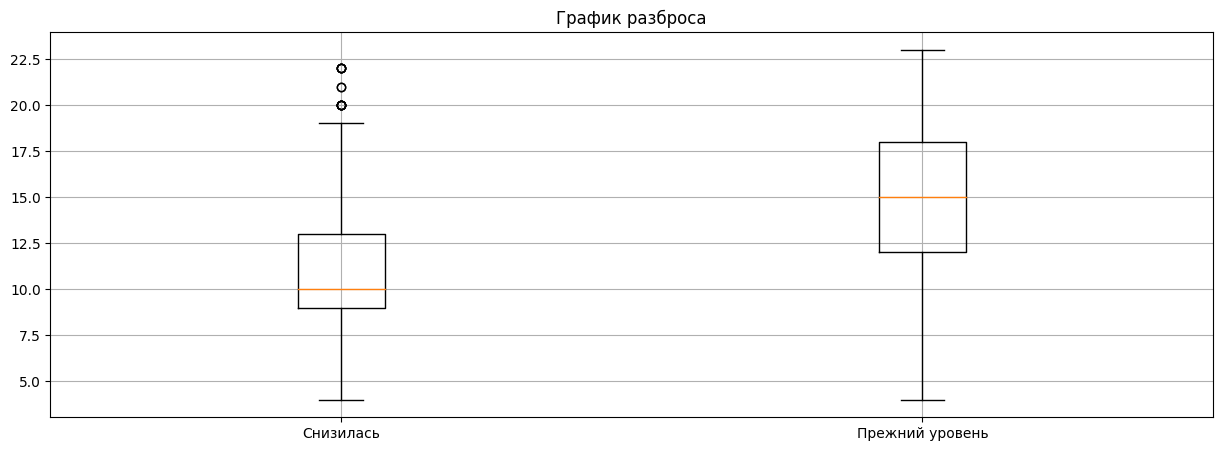

Распределение не является нормальным, p-значение = 1.52877949015362e-12


In [39]:
control_of_analysis_graphs(df_for_model, 'минут_текущий_месяц', \
                           'Минуты проведенные на сайте', \
                           'Анализ минут проведенных на сайте за текущий месяц', (0, 23))

- видны выбросы в данных, однако мы не будем их удалять, так как они не являются аномальными
- по результатам теста Шапиро-Уилка можно отклонить нулевую гипотезу о нормальности данного распределния.
- клиенты со снижающейся покупательской активностью намного меньше минут проводят на сайте.

### Таблица money

#### 1) Прибыль (прибыль магазина от продаж каждому покупателю)
<a id='прибыль'></a>

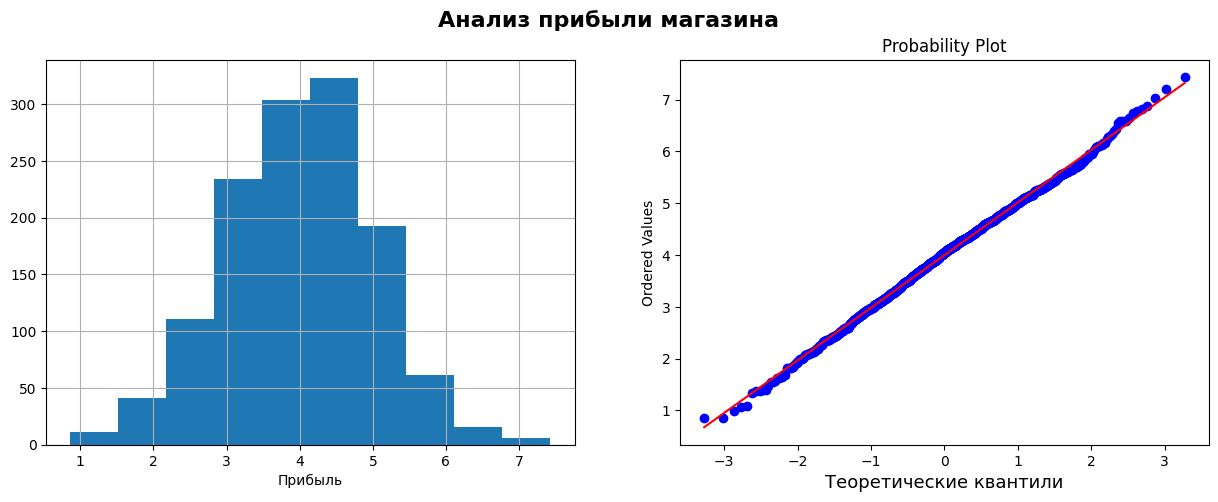

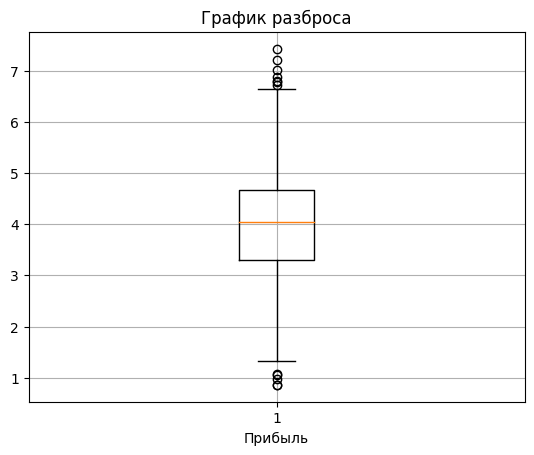

Распределение нормальное, p-значение = 0.2580398917198181


In [40]:
plt.figure(figsize=(15, 5));
plt.suptitle('Анализ прибыли магазина', fontweight='bold', fontsize=16)
plt.subplot(1, 2, 1)
df_money['прибыль'].hist();
plt.xlabel('Прибыль')
plt.subplot(1, 2, 2)
probplot(df_money['прибыль'], plot=plt)
plt.xlabel('Теоретические квантили', fontsize=13)
plt.show()
plt.boxplot(df_money['прибыль']);
plt.title('График разброса')
plt.xlabel('Прибыль')
plt.grid()
plt.show()
shapiro_test(df_money, 'прибыль')

- есть незначительные выбросы, оставим их
- по результатам теста Шапиро-Уилка мы не имеем оснований отбросить нулевую гипотезу о нормальности данного распределения. Q-Q plot показывает нормальность распределения и на гистограмме это так же заметно

### *Вывод:*
    - исследовали все признаки во всех таблицах, разбив данные на группы с и без снижения покупательской активности (построили гистограммы, графики разброса, q-q plot и столбчатые диаграммы)
    - удалили выбросы в признаке выручка в таблице market_money
    - все распределения являются ненормальными, кроме прибыли в таблице money
    - отобрали только тех клиентов, у которых покупательская активность была на протяжении трех или более месяцев
    - объединили таблицы

 ## Корреляционный анализ

### Heatmap

Изучим взаимосвязь между входными и целевым признаками. Для рассчета корреляции будем использовать коэффициент корреляции Спирмена, так как признаки распределены ненормально.

Построим heatmap только для количественных признаков и целевог признака

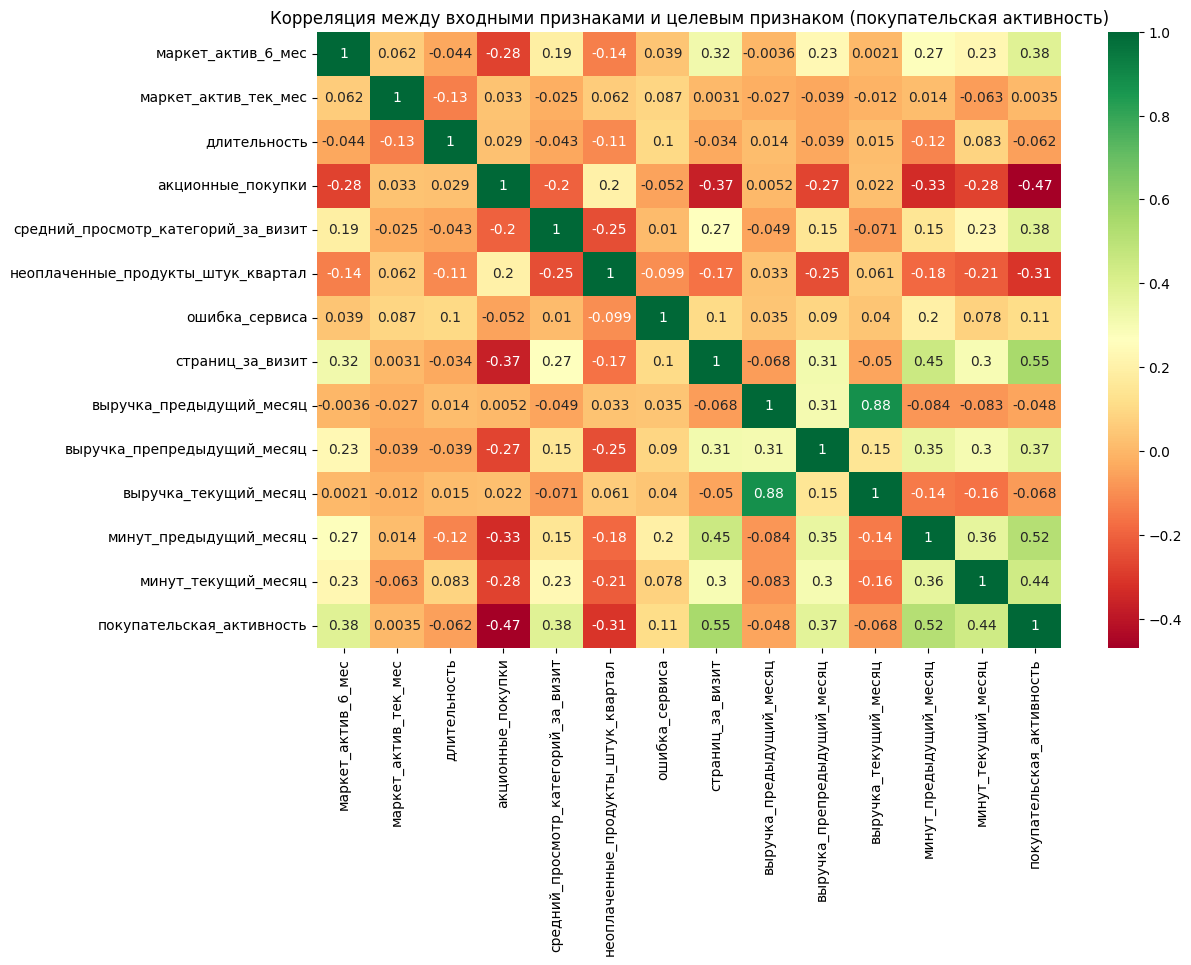

In [41]:
pd.options.mode.chained_assignment = None
corr_table = df_for_model.select_dtypes('number')
corr_table['покупательская_активность'] = pd.factorize(df_for_model['покупательская_активность'])[0]

plt.figure(figsize=(12, 8))
plt.title('Корреляция между входными признаками и целевым признаком (покупательская активность)')
sns.heatmap(corr_table.drop('id', axis=1).corr(method='spearman'), annot=True, cmap='RdYlGn');

Заметим, что целевой признак больше всего коррелирует с признаками `страниц_за_визит`, `минут_препредыдущий_месяц`, `минут_текущий_месяц`, `маркет_актив_6_мес`, `минут_предыдущий_месяц`, `средний_просмотр_категорий_за_визит`. Так же наблюдается сильная отрицательная корреляция с признаками `акционные_покупки`, `неоплаченные_продукты_штук_квартал`.

### *Вывод:*
    - построили матрицу корреляций Спирмена
    - выявили более коррелирующие признаки с целевым признаком

## Использование пайплайнов

### Начальный пайплайн. 

Разобьем данные на выборки

In [42]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X = df_for_model.drop(['id', 'покупательская_активность'], axis=1)
y = df_for_model['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=df_for_model['покупательская_активность'])

Создаем списки с названиями признаков

In [43]:
num_columns = X_train.select_dtypes('number').columns.tolist()
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()

Пайплайн для OneHotEncoder

In [44]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False))
    ]
)

Создаем общий пайплайн

In [45]:
preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns), 
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

Создаем итоговый пайплайн

In [46]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

In [47]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'минут_предыдущий_месяц',
                                                   'минут_текущий_месяц'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

### Пайплайн для подбора моделей и гиперпараметров

Составим пайплайн для перебора моделей и гиперпараметров.

In [48]:
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': [0.001 * 10**i for i in range(7)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': [0.001 * 10**i for i in range(7)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [49]:
search = GridSearchCV(pipe_final, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать',
                                                                          'популярная_категория']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['марк...
                         {'models': [LogisticRegression(random_state=42,
                                                        solver='liblinear')],
                          'models__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                        1000.0],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                        1000.0],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

Получим лучшую модель и ее метрику. Выбрал метрику roc-auc, так как:
- перед нами стоит задача бинарной классификации, а roc-auc хорошо для нее подходит
- показывает отношение между долей верных положительных результатов (True Positive Rate) и долей ложных положительных результатов (False Positive Rate). В нашем случае это важно, так как модель должна правильно классифицировать клиентов, которые снизили активность (True Positives) и не ошибалась в предсказании активных клиентов (False Positives).
- устойчива к дисбалансу классов

In [50]:
search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'минут_предыдущий_месяц',
                                                   'минут_текущий_месяц'])])),
                ('models', SVC(C=0.1, probability=True, random_state=42))])

In [51]:
print('roc-auc:', round(search.best_score_, 3))

roc-auc: 0.911


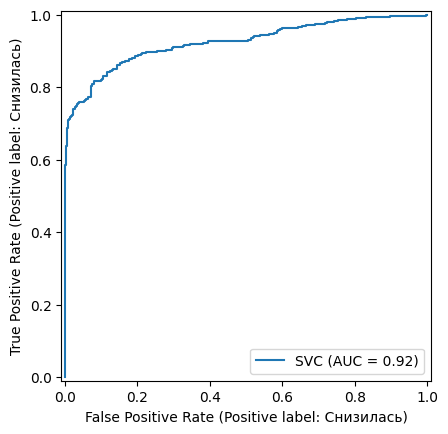

In [52]:
X_train_encoder = preprocessor.fit_transform(X_train)
RocCurveDisplay.from_estimator(search.best_estimator_['models'], X_train_encoder, y_train);

### Проверим качество выбранной модели на тестовой выборке

Рассчитаем roc-auc

In [53]:
print('roc-auc:', round(roc_auc_score(y_test, search.predict_proba(X_test)[:, 1]), 3))

roc-auc: 0.911


Метрика roc-auc на тестовой выборке такая же, как и на тренировочной выборке

Рассчитаем accuracy_precision и recall по тестовой выборке. Выведем матрицу ошибок.

Accuracy: 0.917
Recall: 0.805
Precision: 0.971


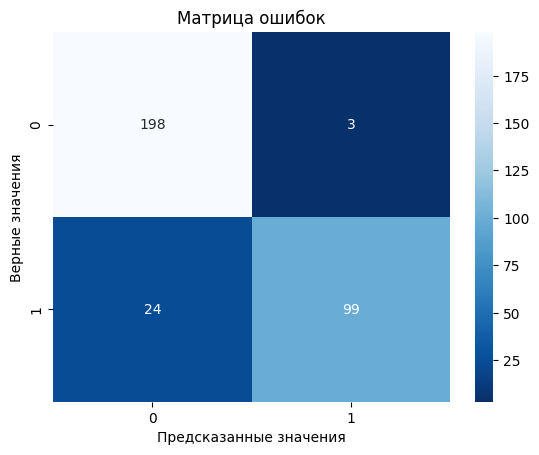

In [54]:
predictions = search.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Верные значения')
plt.xlabel('Предсказанные значения');
print(f'Accuracy: {round(accuracy_score(y_test, predictions), 3)}' 
      f'\nRecall: {round(recall_score(y_test, predictions, pos_label="Снизилась"), 3)}' \
      f'\nPrecision: {round(precision_score(y_test, predictions, pos_label="Снизилась"), 3)}')

Обученная модель дает около 92% верных ответов по результатам рассчета accuracy. Причем, как показывает recall, в 80% случаев модель правильно определяет положительные результаты(Снизилась) и в 97% случаев правильно определяет отрицательные результаты(Прежний уровень) по данным precision.


### *Вывод:*

    - создали пайплайн, где применили все изученные модели и перебрали большое количество гиперпараметров.
    - определили лучшую модель для работы SVC(C=0.1, probability=True, random_state=42)
    - посчитали метрику roc-auc и оценили качество модели.
    - проверили качество модели на тестовых данных. Построили матрицу ошибок и рассчитали accuracy, recall и precision

## Анализ важности признаков

Заметим, что лучшая модель это SVC с ядром rbf. Ее не очень удобно использовать в SHAP. Проверим, возможно SVC с ядром linear покажет приблизительно такую же метрику.

In [55]:
X_test_encoder = preprocessor.transform(X_test)
linear_SVC = SVC(C=0.1, probability=True, kernel='linear', random_state=42)

In [56]:
X_test_encoder = pd.DataFrame(X_test_encoder, columns=preprocessor.get_feature_names_out())

In [57]:
linear_SVC.fit(X_test_encoder, y_test)

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

In [58]:
round(roc_auc_score(y_test, linear_SVC.predict_proba(X_test_encoder)[:,1]), 3)

0.92

Показатель roc-auc для ядра linear стал даже лучше, чем для rbf. Будем использовать эту модель для SHAP

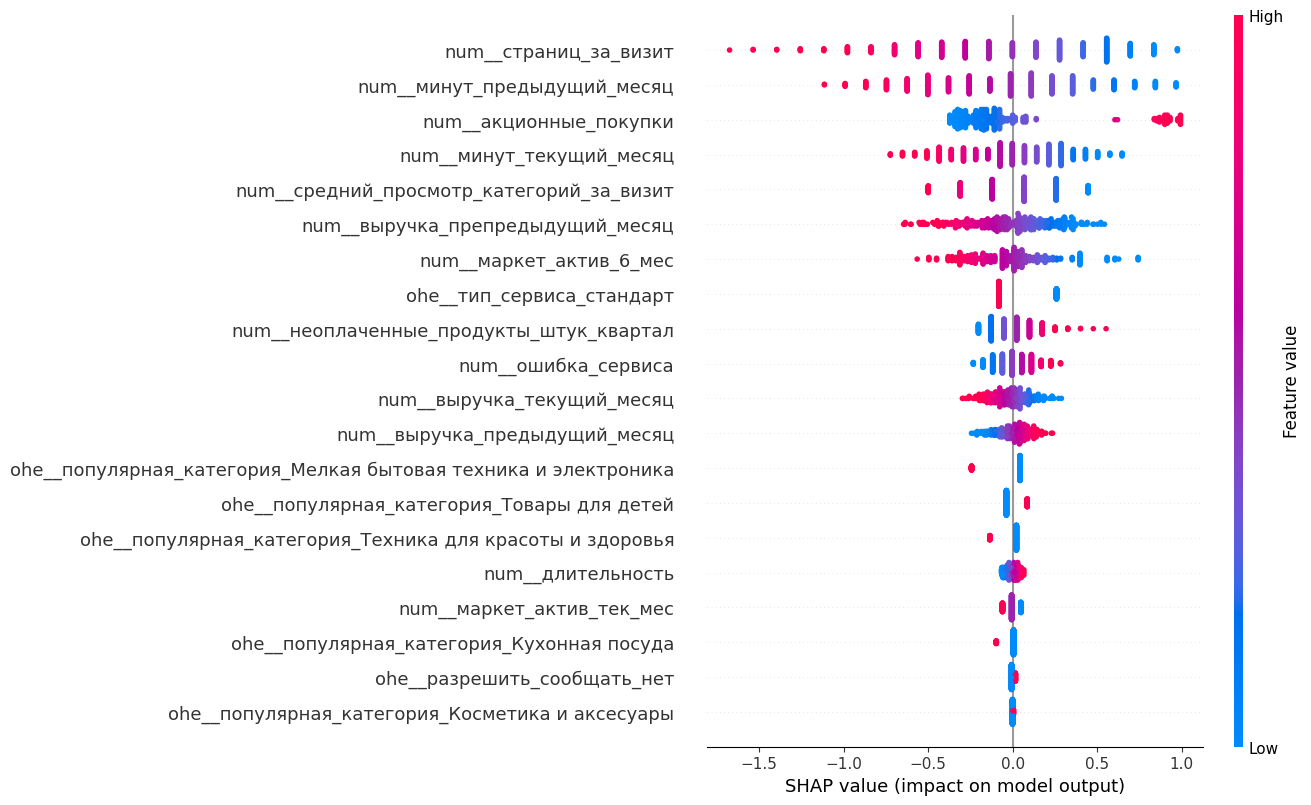

In [59]:
explainer = shap.LinearExplainer(linear_SVC, X_test_encoder)
shap_values = explainer(X_test_encoder)
shap_values.feature_names = list(X_test_encoder.columns)
shap.plots.beeswarm(shap_values, max_display=len(X_test_encoder.columns))

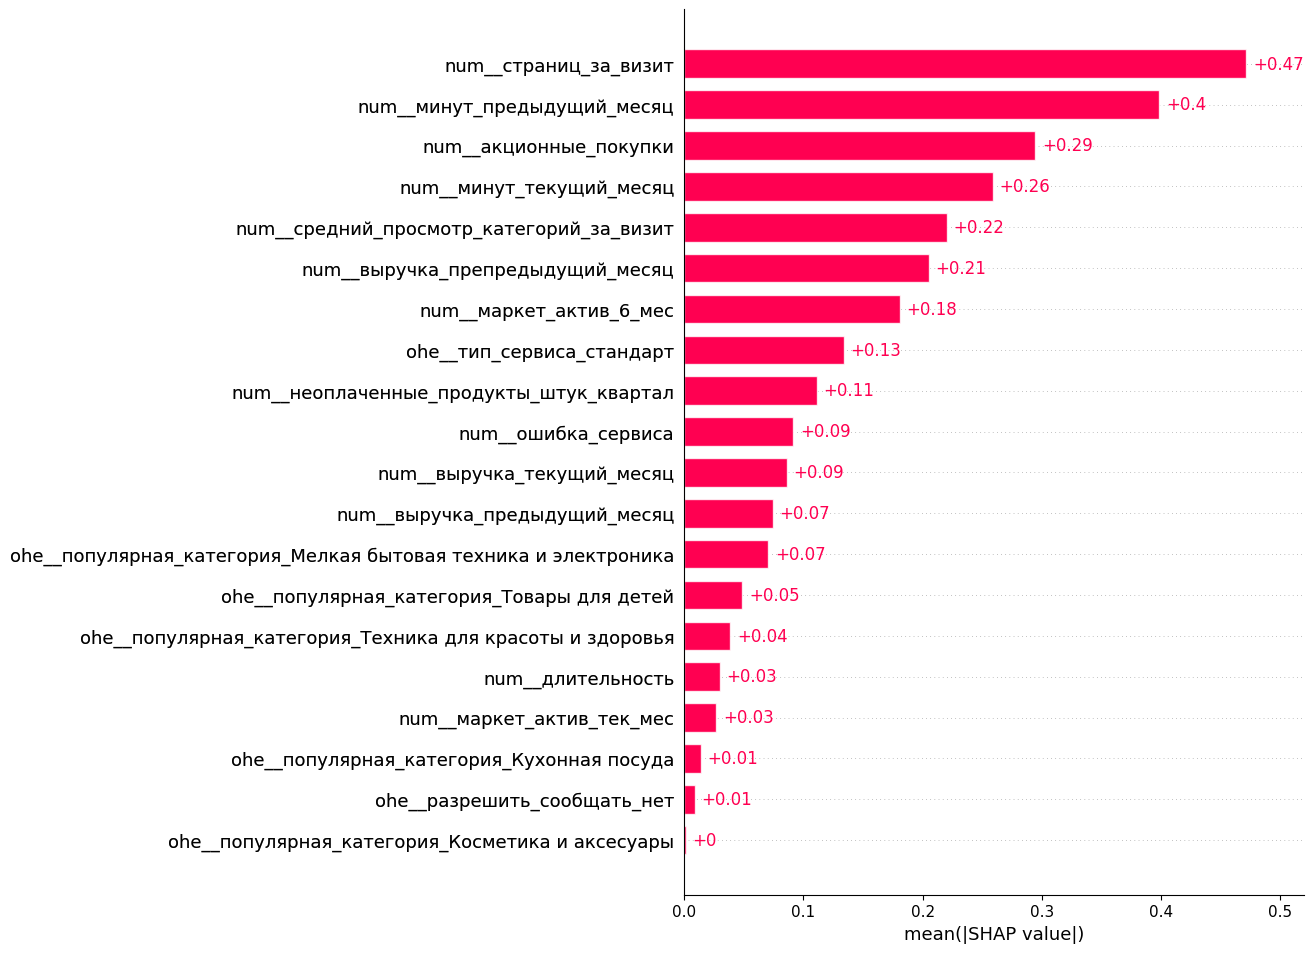

In [60]:
shap_values.feature_names = list(X_test_encoder.columns)
shap.plots.bar(shap_values, max_display=len(X_test_encoder.columns))

Как показывает SHAP, самыми маловажными признаками являются: `популярная_категория`, `разрешить_сообщать`, `маркет_актив_тек_мес`, `длительность`, `выручка_текущий_месяц`, `выручка_предыдущий_месяц`, `ошибка сервиса`

Сильнее всего влияют признаки: `страниц_за_визит`, `минут_предыдущий месяц`, `акционные покупки`, `минут текущий месяц`, `средний просмотр категорий за визит`, `выручка препредыдущий месяц`

Эти наблюдения помогут состредоточиться на более важных признаках при моделировании и исключить бесполезные. А так же помогут сегментировать клиентов и делать персональные предложения каждой группе

### *Вывод:*
    - проанализировали важность признаков. выделили наиболее и наименее важные из них
    

## Сегментация покупателей

Выделим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Будем рассматривать только те признаки, которые сильнее всего влияют на покупательскую активность клиентов

In [61]:
proba = search.predict_proba(X)[:, 1]
df_for_model = df_for_model.merge(df_money, on='id')
df_for_model['вероятность_снижения_покупательской_активности'] = proba

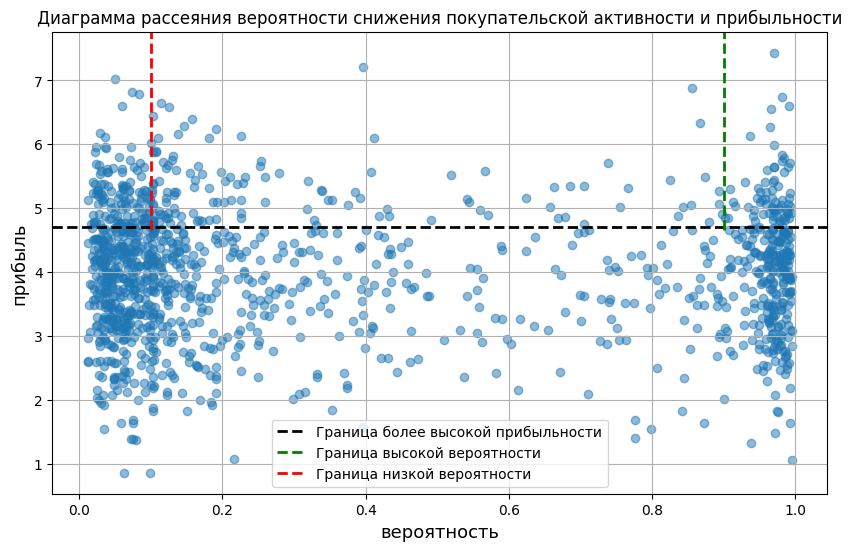

In [62]:
x_ax = df_for_model['вероятность_снижения_покупательской_активности']
y_ax = df_for_model['прибыль']


# cтроим скаттерплот
plt.figure(figsize=(10, 6))
plt.scatter(x=x_ax, y=y_ax, alpha=0.5);
plt.axhline(y=4.7, color='k', linestyle='--', label='Граница более высокой прибыльности', linewidth=2)
plt.axvline(x=0.9, color='g', linestyle='--', label='Граница высокой вероятности', ymin=0.57, ymax=1, linewidth=2)
plt.axvline(x=0.1, color='r', linestyle='--', label='Граница низкой вероятности', ymin=0.57, ymax=1, linewidth=2)
plt.xlabel('вероятность', fontsize=13)
plt.ylabel('прибыль', fontsize=13)
plt.legend()
plt.title('Диаграмма рассеяния вероятности снижения покупательской активности и прибыльности')
plt.grid(True)


Глядя на график рассеяния можно выделить группу с высокой вероятностью снижения покупательской активности и высокой прибыльностью. Границу более высокой прибыльности будем считать значение 4.7, так как это значение соответствует третьему квантилю ([см.здесь](#прибыль)), а значит клиенты с такой прибыльностью входят в 25% клиентов. Границу высокой вероятности снижения активности будем считать значение 0.9.


Здесь же выделим группу клиентов с большой прибыльностью, но у которых низкая вероятность снижения активности. Границу низкой вероятности снижения активности возьмем за 0.1



In [63]:
df_segment_high_prob = df_for_model[(df_for_model['вероятность_снижения_покупательской_активности'] >= 0.9) \
                                    & (df_for_model['прибыль'] >= 4.7)]
df_segment_low_prob = df_for_model[(df_for_model['вероятность_снижения_покупательской_активности'] <= 0.1) \
                                   & (df_for_model['прибыль'] >= 4.7)]

# уберем ошибочно попавших в эти подгруппы пользователей
df_segment_low_prob = df_segment_low_prob[df_segment_low_prob['покупательская_активность'] == 'Прежний уровень']
df_segment_high_prob = df_segment_high_prob[df_segment_high_prob['покупательская_активность'] == 'Снизилась']

Проводя исследовательский анализ, можно было заметить, что некокоторые клиенты приходят только на акционные предложения, но больше на сайте не задерживаются, скорее всего данная закономерность относится и к выбранному сегменту. Изучим этот момент.

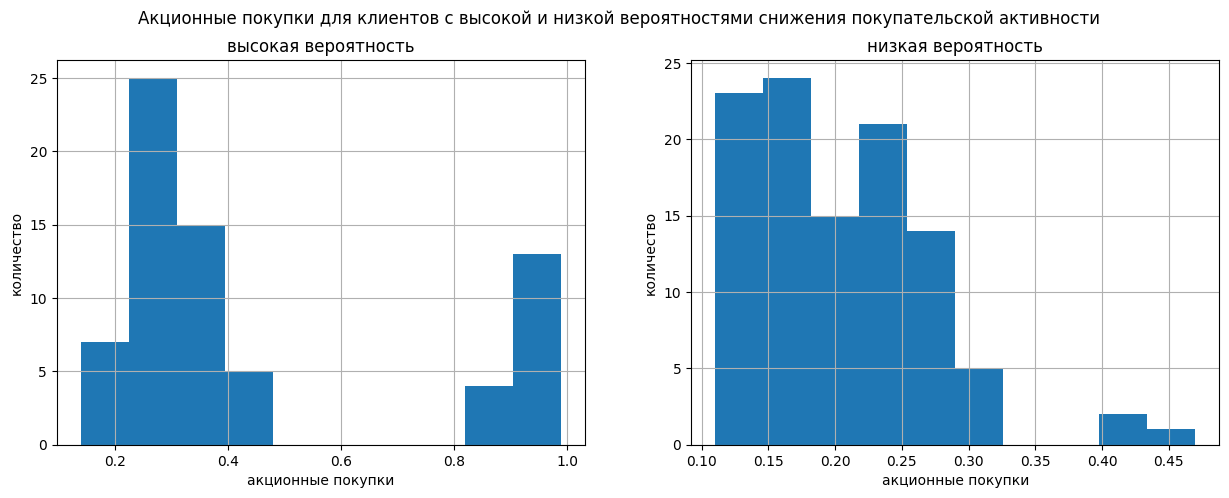

In [64]:
plt.figure(figsize=(15,5))
plt.suptitle('Акционные покупки для клиентов с высокой и низкой вероятностями снижения покупательской активности')
plt.subplot(1, 2, 1)
df_segment_high_prob['акционные_покупки'].hist()
plt.xlabel('акционные покупки')
plt.ylabel('количество')
plt.title('высокая вероятность')
plt.subplot(1, 2, 2)
df_segment_low_prob['акционные_покупки'].hist()
plt.xlabel('акционные покупки')
plt.ylabel('количество')
plt.title('низкая вероятность');
plt.show()

Отчетливо видно, что среди клиентов, с высокой долей вероятности снижения активности есть группа клиентов, которые покупали товары почти исключительно по акциям.

Проверим количество покупок в данных сегментах по популярным категориям

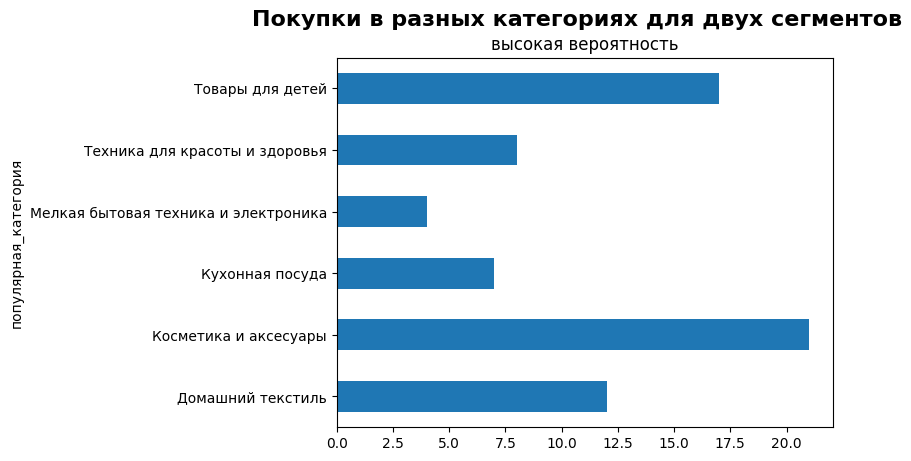

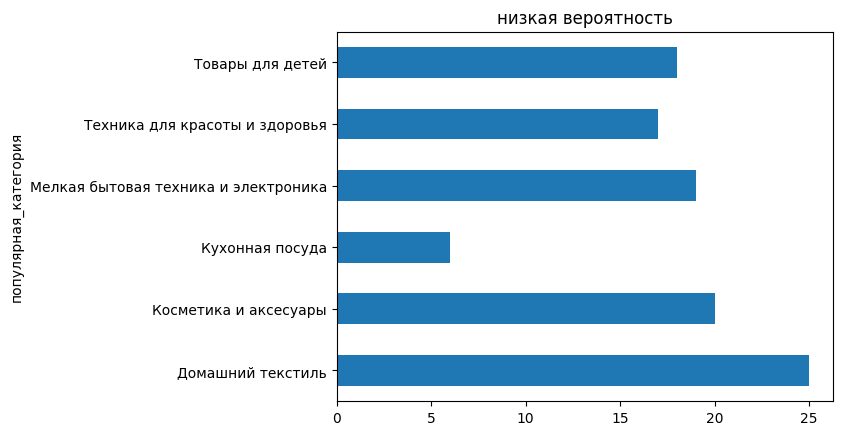

In [65]:
df_segment_high_prob.pivot_table(index='популярная_категория', values='id', aggfunc='count').plot(kind='barh')
plt.suptitle('Покупки в разных категориях для двух сегментов', fontweight='bold', fontsize=16)
plt.title('высокая вероятность')
plt.legend().set_visible(False)
df_segment_low_prob.pivot_table(index='популярная_категория', values='id', aggfunc='count').plot(kind='barh')
plt.title('низкая вероятность')
plt.legend().set_visible(False)


В данных сегментах так же прослеживается закономерность, что у клиентов с высокой вероятностью снижения покупательской активности, любимой категорией намного реже являются категории связанные с техникой (мелкой бытовой, для красоты), чем у клиентов с низкой вероятностью снижения покупательской активности

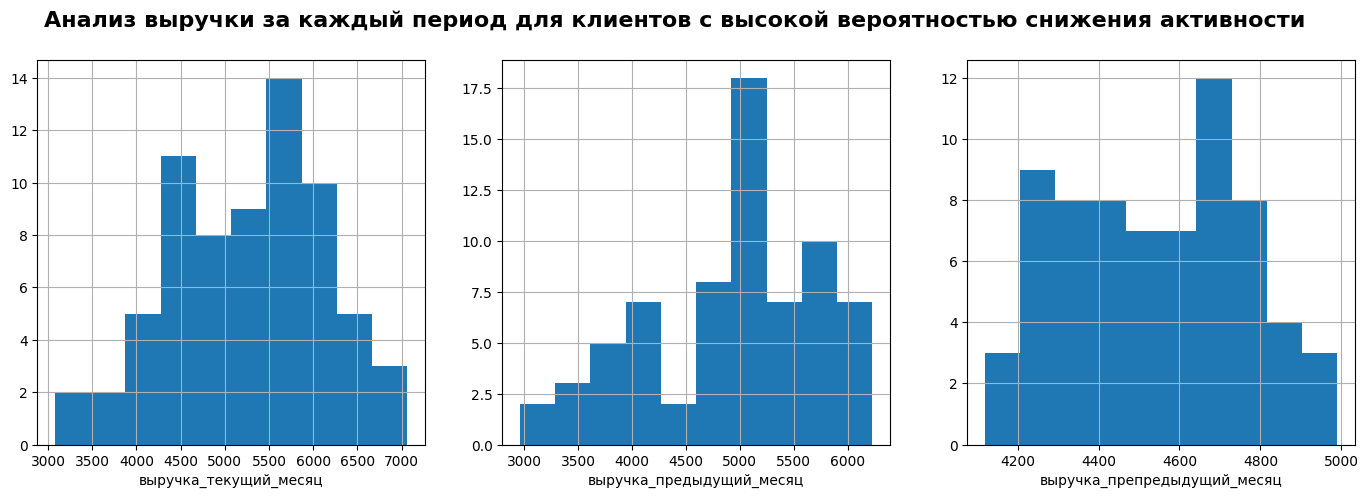

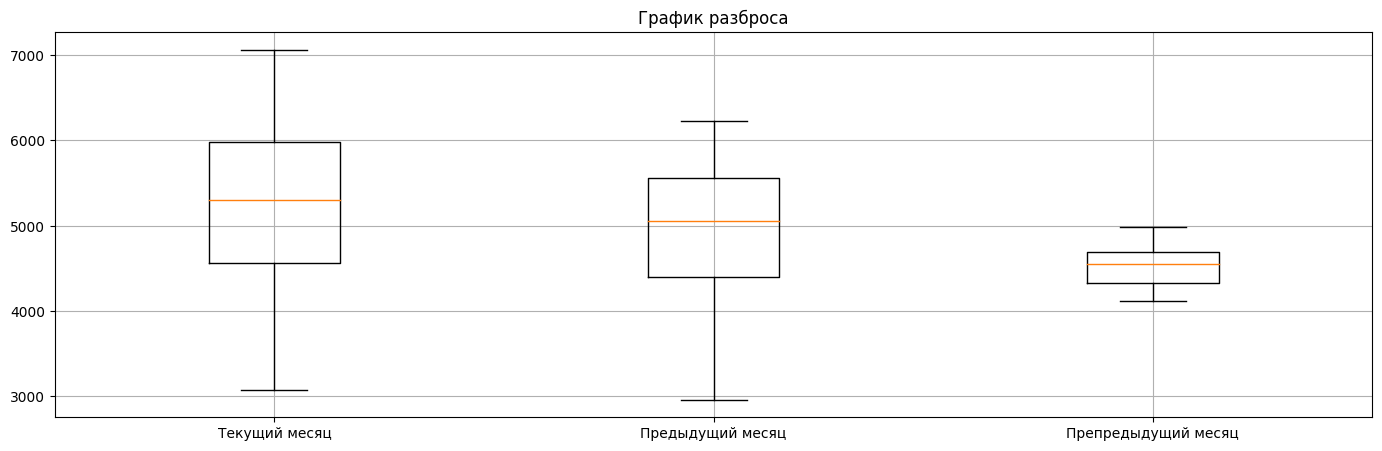

In [66]:
def box_hist_func(df, suptitle):
    plt.figure(figsize=(17, 5))
    plt.suptitle('Анализ выручки за каждый период для клиентов с высокой вероятностью снижения активности', \
                 fontweight='bold', fontsize=16)
    for i, j in {1:'выручка_текущий_месяц', 2: 'выручка_предыдущий_месяц', \
                 3: 'выручка_препредыдущий_месяц'}.items():
        plt.subplot(1, 3, i)
        df_segment_high_prob[j].hist()
        plt.xlabel(j)

    plt.figure(figsize=(17, 5));
    ax = plt.subplot()
    ax.boxplot(df_segment_high_prob[['выручка_текущий_месяц', 'выручка_предыдущий_месяц', \
                                     'выручка_препредыдущий_месяц']])
    ax.set_xticklabels(['Текущий месяц', 'Предыдущий месяц', 'Препредыдущий месяц'])
    plt.title('График разброса')
    plt.grid()
    plt.show()

box_hist_func(df_segment_high_prob, \
              'Анализ выручки за каждый период для клиентов с высокой вероятностью снижения активности')

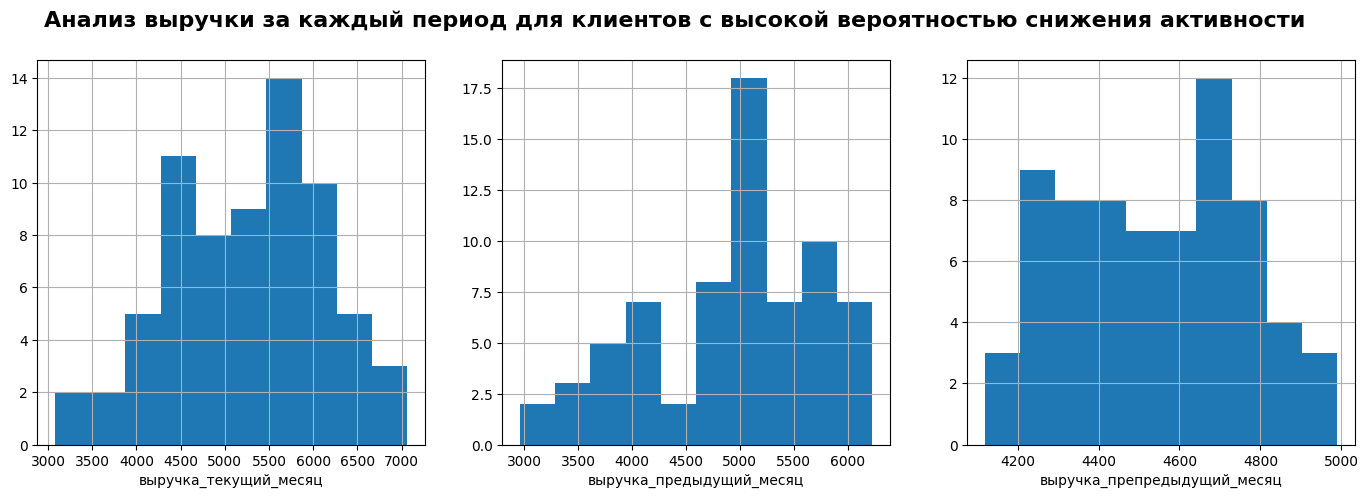

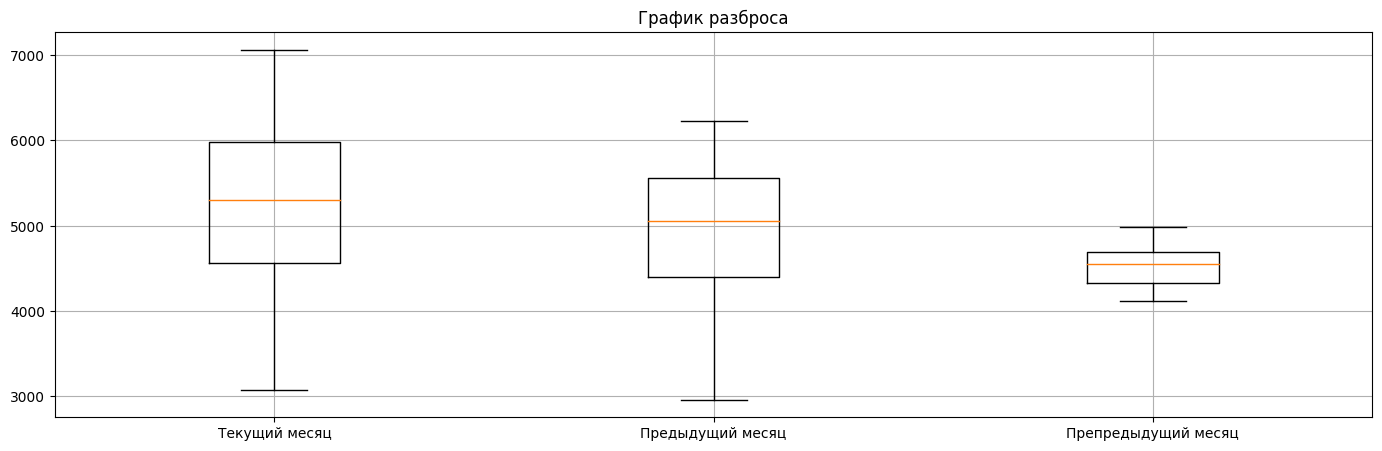

In [67]:
box_hist_func(df_segment_high_prob, \
              'Анализ выручки за каждый период для клиентов с низкой вероятностью снижения активности')

Заметна интересная закономерность. Прибыльность от клиентов с высокой вероятностью снижения активности повышалась на протяжении трех месяцев, а от клиентов с прежней покупательской активностью прибыльность оставалась на одном уровне на протяжении трех месяцев. Возможно это связано с тем, что на текущий месяц выпало больше акций, или же это пик выручки, которая вероятно пойдет на снижение после этого месяца

### Рекомендации:

Так как отчетливо видно, что в выбранном сегменте есть немаленькая часть покупателей, которые делают свои покупки исключительно по акциям, возможно стоит проводить акции и скидки на регулярной основе, что бы побуждать их на дополнительные покупки. Причем видно, что такие клиенты в меньшем количестве делают покупки в категории мелкой бытовой техники и техники для красоты и здоровья. Возможно эти категории отличаются более высокими ценами и стоит так же рассмотреть возможность введения скидок именно на эти товары, что бы позволить покупателям с любым финансовым положением делать покупки на сайте и в проседающих категориях в том числе.

Возможно стоит ввести программу лояльности, чтобы удержать клиентов которые покупают товары только по скидке, и дать им возможность продолжить совершать покупки с небольшими бонусами и скидками за каждую покупку, что опять же позволит им активнее себя проявлять в категориях с наиболее высокими ценами.



### *Вывод:*
- был взят сегмент: группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.
- предложения: 
         - проводить регулярные акции на товары, в особенности в категориях с наиболее высокими ценами (мелкая бытовая техника и техника для красоты и здоровья)
         - вводить дополнительные скидочные предложения на товары длительного пользования
         - стоит рассмотреть введения программы лояльности для удержания группы клиентов, которые покупают товары только по акциям

## Общий вывод

Задача:
 - Разработать модель, для предсказывания покупательской способности клиентов. 
 - Выделите сегмент покупателей, проанализировать его и разработать предложения, как увеличить его покупательскую активность.
 
Исходные данные:
 - market_file.csv: таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 - market_money.csv: таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
 - market_time.csv: таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - money.csv: таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 
Предобработка:
 - изменили названия столбцов
 - удалили дубликаты
 - исправили опечатки в данных

Поиск лучшей модели:
 - использовали автоматический поиск гиперпараметров GridSearchCV
 - перебрали гиперпараметры и различные модели для поиска лучшего сочетания
 - проверили качество модели на метрике ROC-AUC
 
Лучшая модель:
 - SVC(C=0.1, probability=True, random_state=42)
 
Дополнительные предложения:
 - возможно введение реферальной программы для клиентов, что опять же позволит части клиентам, которые покупают только по акциям, задержаться на сайте и плюс к этому привлечь к магазину еще больше клиентов